Las cuatro redes de proteínas de levadura que
disponemos: Y2H, AP-MS, LIT y Lit-Reguly. Las dos últimas son redes construidas a partir de
interacciones reportadas en la literatura. 

In [1]:
#librerias a utilizar
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as scipy

In [2]:
#Para abrir archivos
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    if os.path.basename(nombre_archivo) == 'yeast_LIT_Reguly.txt':
        data = data[1:]
        enlaces = []
        for linea in data:
            enlaces.append(linea[:2])
        return(enlaces)
    if os.path.basename(nombre_archivo) == 'Essential_ORFs_paperHe.txt': 
        data = data[2:]
        esenciales = []
        for linea in data:
            if len(linea)>2:
                esenciales.append(linea[1])
        return esenciales
    else:
        return data

def crear_redes(red):
    lista_de_enlaces = abrir_txt(red)
    Red = nx.Graph()
    Red.add_edges_from(lista_de_enlaces)
    return Red

In [3]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'AP_MS': './data/yeast_AP-MS.txt',
         'Lit': './data/yeast_LIT.txt',
         'Lit_reg': "./data/yeast_LIT_Reguly.txt"
         }
redes_dict = {}

for red in redes:
    grafo = crear_redes(redes[red])
    redes_dict[red] = {}
    redes_dict[red]["Grafo"] = grafo

In [8]:
def get_red_info(nombre_red):
    
    red = redes_dict[nombre_red]
    grafo = red['Grafo']
    red['Nodos'] = grafo.number_of_nodes() 
    red['Enlaces'] = grafo.number_of_edges()
    red['Grado medio'] = 2 * red['Enlaces'] / red['Nodos']
    red['Clustering medio'] = nx.average_clustering(grafo)   

In [9]:
for red in redes_dict.keys():
    get_red_info(red)

In [4]:
lista_esenciales = abrir_txt('./data/Essential_ORFs_paperHe.txt')

En la figura 2.b del paper de He se analiza la probabilidad que tiene un nodo de ser esencial. 
Primero de todo se evalua la fracción de enlaces esenciales $\alfa$ y la fracción de nodos esenciales $\beta$ para luego aplicar la fórmula susodicha de probabilidad

$P_{E} = 1 - (1- \beta)(1-\alpha)^{k}$  Donde k es la conectividad de la red.

En la figura que simularemos se utiliza la probabilidad linealizada $ln(1-P_{E}) = kln(1-\alpha) + ln(1-\beta)$



El parámetro $\beta$ viene dado por los nodos esenciales -listados en unos de los archivos- sobre el total de nodos de la red.
Por otro lado, el factor $\alfa$ no es trivial ya que no todos los enlaces entre nodos esenciales son esenciales.
Para estimar el parámetro se parte de la premisa que afirma que todos los nodos enlazados entre nodos esenciales son esenciales. Por ende, para estimarlo vamos a recablear la red manteniendo su conectividad. La cantidad de enlaces esenciales estimada va a ser la diferecia entre el numero de IBEPs de la red real y la de la media de los recableados.


In [33]:
import time
import itertools
import random

def IBEP(red,lista_esenciales): #calcula el numero de interacciones entre nodos esenciales
    esenciales_en_red = list(set(red.nodes()).intersection(lista_esenciales))
    interacciones_nodos_esenciales = 0
    for i in range(0, len(esenciales_en_red)):
        for j in range(i,len(esenciales_en_red)):
            if not red.number_of_edges(esenciales_en_red[i],esenciales_en_red[j]) == 0:
                interacciones_nodos_esenciales += 1
                
    return interacciones_nodos_esenciales


#Este recableado mantiene el grado
def recableado_IBEPs(red,num_recableos):
    Red = redes_dict[red]['Grafo'].copy()
    nodos = Red.nodes()
    lista_IBEP = []
    
    for i in range(num_recableos): #la recableo n veces:
        start = time.time()
        Red_recableada = nx.double_edge_swap(Red, nswap=0.2*redes_dict[red]['Nodos'], max_tries=0.3*redes_dict[red]['Nodos'],)
        end = time.time()
        #print(f'El recableo de la red {red} tardó {round(end - start, 2)}s')
        IBEPs = IBEP(Red_recableada,lista_esenciales) #calcula el numero de IBEP
        lista_IBEP.append(IBEPs)
        
    return lista_IBEP

def recableado_nodos(red,lista_esenciales,alfa,num_recableos):
    Red = redes_dict[red]['Grafo'].copy()
    prob_ibps = np.round(alfa,3)
    interacciones = Red.edges()
    nodos = Red.nodes()
    lista_cant_faltantes = []
    lista_esenciales_nueva =  [nodo for nodo in lista_esenciales if nodo in nodos]
    
    for i in range(num_recableos): #la recableo n veces:
        
        ibps_random = [] #aca voy a guardar los enlaces que con la probabilidad alfa dieron true
        for i in interacciones:
            ibp_random = np.random.choice([1,0],p=[prob_ibps,1-prob_ibps])
            if ibp_random == 1:
                ibps_random.append(i)

        nodos_esenciales_random = list(set(itertools.chain.from_iterable(ibps_random))) #son los nodos asociados a las ibps random
        cant_faltantes = len(lista_esenciales_nueva) - len(nodos_esenciales_random)
        
        #print(f'El recableo de la red {red} tardó {round(end - start, 2)}s')
        
        lista_cant_faltantes.append(cant_faltantes)
        
    #print(len(lista_esenciales),len(lista_esenciales_nueva))
    return lista_cant_faltantes


def alfa(red,media_recableado,IBPs_original): #definicion del alfa del paper
    frac_int_esenciales = (IBEPs_original - media_recableado) / redes_dict[red]['Enlaces']
    return frac_int_esenciales

    


In [34]:
import random 

#ESTE ES UN RECABLEADO MEDIO FALOPA, queda el otro.
def recableado(red,num_recableos):
    Red = redes_dict[red]['Grafo'].copy()
    lista_IBEP = []
    for i in range(num_recableos): #la recableo n veces:
        start = time.time()
        enlaces_originales = Red.edges()
        e1 = [x[1] for x in enlaces_originales]
        e2 = [x[0] for x in enlaces_originales]
        random.shuffle(e2) #los reacomodo de una manera arbitraria
        enlaces_nuevos = list(zip(e1,e2))
        
        #creo una red nueva 
        Red_recableada=nx.Graph()
        lista_nodos = Red.nodes()
        lista_enlaces = enlaces_nuevos
        Red_recableada.add_nodes_from(lista_nodos)
        Red_recableada.add_edges_from(lista_enlaces)
        
        end = time.time()
        #print(f'El recableo de la red {red} tardó {round(end - start, 2)}s')
        IBEPs = IBEP(Red_recableada,lista_esenciales) #calcula el numero de IBEP
        lista_IBEP.append(IBEPs)
    return lista_IBEP
    

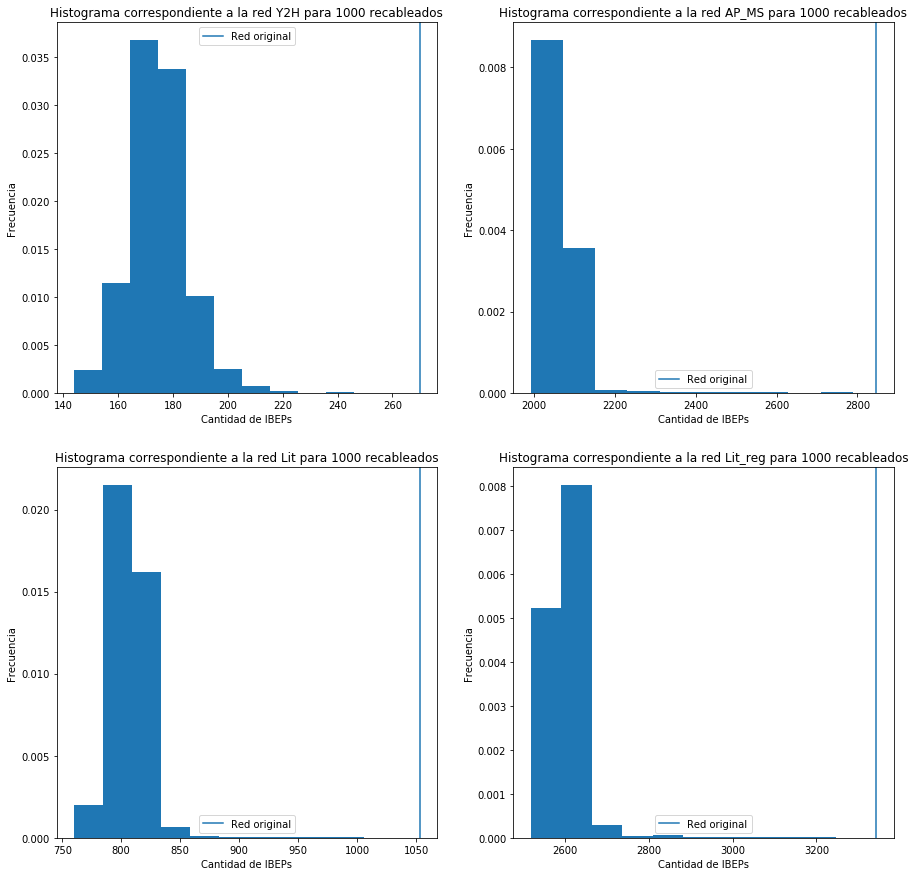

In [35]:
from statistics import mean,stdev

fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()
lista_alfa = []
lista_beta = []
lista_errores_alfa = []
lista_errores_beta = []
lista_IBEPs_original = []
lista_media_recableado = []

for i,red in enumerate(redes_dict.keys()):
    n = 1000
    lista_recableado_enlaces = recableado_IBEPs(red,n) #recableo n veces. Ideal seria 10.000 como en el paper
    
    #busco los valores que necesito
    media_recableado_enlaces = mean(lista_recableado_enlaces)
    IBEPs_original = (IBEP(redes_dict[red]['Grafo'],lista_esenciales))
    alfa_red = alfa(red,media_recableado_enlaces,IBEPs_original)
    error_alfa = stdev(lista_recableado_enlaces)/redes_dict[red]['Enlaces']
    
    #hago el recableado para estimar el beta
    lista_recableado_nodos = recableado_nodos(red,lista_esenciales,alfa_red,n)
    beta_red = mean(lista_recableado_nodos)/redes_dict[red]['Nodos']
    error_beta = stdev(lista_recableado_nodos)/redes_dict[red]['Nodos']
    
    #los guardo en listas
    lista_beta.append(beta_red)
    lista_alfa.append(alfa_red)
    lista_errores_alfa.append(error_alfa)
    lista_errores_beta.append(error_beta)
    lista_IBEPs_original.append(IBEPs_original)
    lista_media_recableado.append(alfa_red)
    
    #grafico
    ax[i].hist(lista_recableado_enlaces,density=True)
    ax[i].set_xlabel('Cantidad de IBEPs')
    ax[i].set_ylabel('Frecuencia')
    ax[i].set_title(f'Histograma correspondiente a la red {red} para {n} recableados')
    ax[i].axvline(IBEPs_original, label = 'Red original')
    ax[i].legend()
plt.show()



In [36]:
print(lista_alfa,lista_beta,lista_errores_alfa,lista_errores_beta)

[0.03251808873720136, 0.08631267916207279, 0.08405743589743592, 0.06223132062742451] [0.14943409316154607, -0.03999260172626387, 0.17549088541666666, -8.769277290595705e-05] [0.003625363056954787, 0.00699067320793123, 0.005843000805853242, 0.004602296999977536] [0.007613449513529814, 0.012390981424113294, 0.01290018495638544, 0.008355214965168877]
